In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import xarray as xr
from plotting_utils import *
from train import *
from MLP import *

parent_dir: /Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS
hi from MLP.py!2


# import data

In [2]:
input_data_60S_so = xr.open_dataset(f"processed_data/input_data_60S_so.nc")
input_data_60S_so = input_data_60S_so.drop(['u', 'v', 'xu_ocean', 'temp_yflux_adv'])
MOC_60S_so = xr.open_dataset(f"processed_data/MOC_60S_so.nc", engine='netcdf4')

In [3]:
input_data_60S_so

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, time: 349)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
    yt_ocean          float64 ...
  * time              (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-1...
    yu_ocean          float64 ...
    st_ocean          float64 ...
Data variables:
    sea_level         (time, xt_ocean) float32 ...
    surface_pot_temp  (time, xt_ocean) float32 ...
    surface_salt      (time, xt_ocean) float32 ...
    pbot_t            (time, xt_ocean) float32 ...

In [4]:
MOC_60S_so.MOC

<xarray.DataArray 'MOC' (time: 349)>
[349 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1989-12-16T12:00:00 ... 2018-12-16T12:00:00
    yu_ocean  float64 ...
    st_ocean  float64 ...
    sigma_2   float64 ...

# preprocess

In [5]:
from utils import *
input_data_60S_so = apply_preprocessing(input_data_60S_so, mode='inputs')
MOC_60S_so = apply_preprocessing(MOC_60S_so, mode='outputs')

In [6]:
from sklearn import model_selection

x = input_data_60S_so.pbot_t 
print(x.shape)
y = MOC_60S_so.MOC

out = model_selection.train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_test, y_train, y_test = out

x_test = x_test.sortby('time')
y_test = y_test.sortby('time')

(349, 3600)


linear regression 

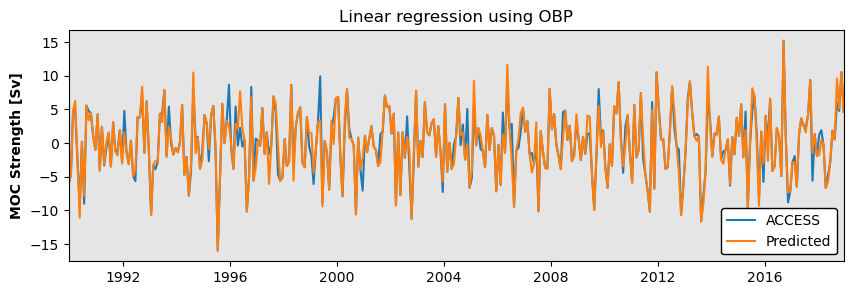

[[1.         0.84326312]
 [0.84326312 1.        ]]
2.5391164011108653
<xarray.DataArray 'MOC' ()>
array(2.07721028)
Coordinates:
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
    yu_ocean  float64 -60.02


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Predicted MOC Strength [Sv]', ylabel='ACCESS MOC Strength [Sv]'>)

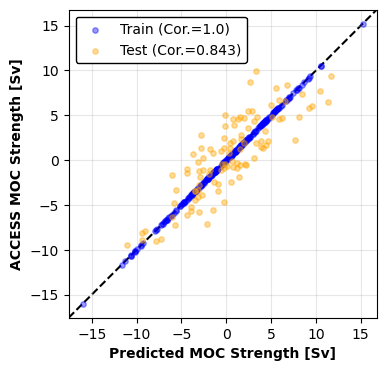

In [7]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse

linreg = linear_model.LinearRegression()

linreg.fit(x_train, y_train)

timeseries_comparison(linreg.predict(x)*1e-6, y*1e-6, x.time, len(x.time), 'ACCESS')
plt.title('Linear regression using OBP')
plt.show()

print(np.corrcoef(linreg.predict(x_test), y_test))
print(np.sqrt(mse(linreg.predict(x_test), y_test))*1e-6)
# print mean absolute error
print(np.mean(np.abs(linreg.predict(x_test) - y_test))*1e-6)

pred_vs_actual(linreg.predict(x_train)*1e-6, linreg.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')

/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[[nan nan]
 [nan  1.]]


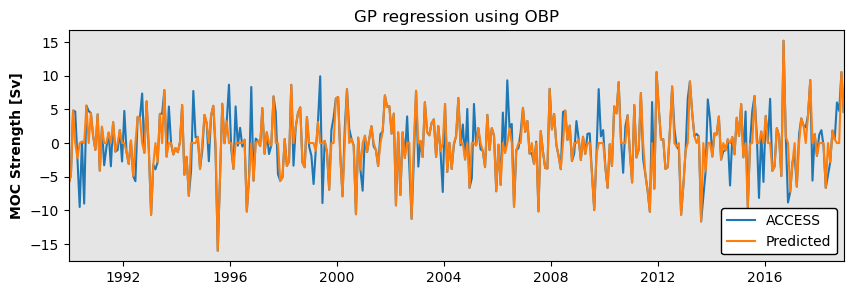

[[nan nan]
 [nan  1.]]
4.521448481796747
<xarray.DataArray 'MOC' ()>
array(3.66412027)
Coordinates:
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
    yu_ocean  float64 -60.02


/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Predicted MOC Strength [Sv]', ylabel='ACCESS MOC Strength [Sv]'>)

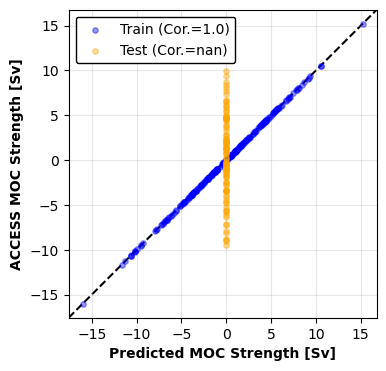

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor()
gp.fit(x_train.to_numpy(), y_train.to_numpy())
print(np.corrcoef(gp.predict(x_test.to_numpy()), y_test.to_numpy()))

# plt.plot(x_test.time, gp.predict(x_test.to_numpy())*1e-6, label='Fitted line (GP)')


timeseries_comparison(gp.predict(x)*1e-6, y*1e-6, x.time, len(x.time), 'ACCESS')
plt.title('GP regression using OBP')
plt.show()

print(np.corrcoef(gp.predict(x_test), y_test))
print(np.sqrt(mse(gp.predict(x_test), y_test))*1e-6)
print(np.mean(np.abs(gp.predict(x_test) - y_test))*1e-6)

pred_vs_actual(gp.predict(x_train)*1e-6, gp.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')


First attempt at ESN

[[1.         0.56814499]
 [0.56814499 1.        ]]
4.023120618177483
<xarray.DataArray 'MOC' ()>
array(3.29399211)
Coordinates:
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
    yu_ocean  float64 -60.02


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/ESN.py:109: UserWarning: Data must be sorted by time for ESN.
  warn("Data must be sorted by time for ESN.")


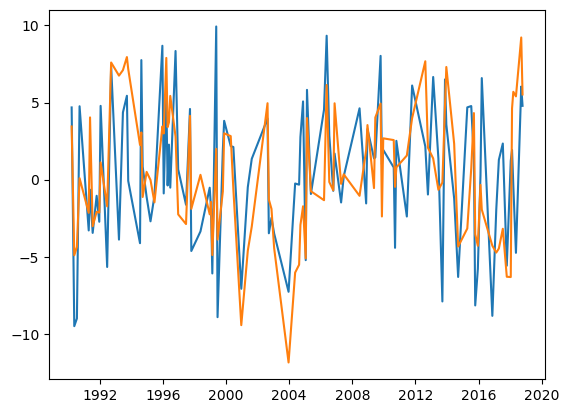

In [9]:
from ESN import ESN

res_model = ESN(3600, 100, 'full', 'full', 20)
res_model.fit(x_train.to_numpy(), y_train.to_numpy())

plt.plot(x_test.time, y_test*1e-6, label='Actual MOC')
plt.plot(x_test.time, res_model.predict(x_test.to_numpy())*1e-6, label='Fitted line (ESN)')

print(np.corrcoef(res_model.predict(x_test.to_numpy()), y_test))
print(np.sqrt(mse(res_model.predict(x_test.to_numpy()), y_test))*1e-6)
print(np.mean(np.abs(res_model.predict(x_test.to_numpy()) - y_test))*1e-6)

MLPs (Solodoch architecture included)

In [27]:
import torch

x_tensor = torch.from_numpy(x.to_numpy()).to(torch.float32)
y_tensor = torch.from_numpy(y.to_numpy()).to(torch.float32)

max_layer_num = 1
max_hidden_units = 5
min_dropout, max_dropout, n_dropout = 0.1, 0.5, 5
min_lr, max_lr, n_lr = 0.01, 0.01, 1

torch.float32


In [28]:
for n_layers in range(1, max_layer_num+1):
    for n_hidden in range(1, max_hidden_units+1):
        for dropout in np.linspace(min_dropout, max_dropout, n_dropout):
            for lr in np.linspace(min_lr, max_lr, n_lr):
                print(f'Running MLP with {n_layers} layers, {n_hidden} hidden units, dropout {dropout} and lr {lr}')
                mlp = MLP(3600, n_layers, n_hidden, dropout)
                train_model(mlp, f'MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP', x_tensor, y_tensor, '../ACCESS', lr=lr)

Running MLP with 1 layers, 1 hidden units, dropout 0.1 and lr 0.01
device: cpu
3603 parameters.


100%|██████████| 5000/5000 [00:04<00:00, 1087.98it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_1H_drop0.1_lr0.01_OBP.pt
final RMSE loss: 4.352723004413673 Sv
model saved to ../ACCESS/saved_models/MLP_1L_1H_drop0.1_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_1H_drop0.1_lr0.01_OBP.png
Running MLP with 1 layers, 1 hidden units, dropout 0.2 and lr 0.01
device: cpu
3603 parameters.


100%|██████████| 5000/5000 [00:04<00:00, 1139.43it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_1H_drop0.2_lr0.01_OBP.pt
final RMSE loss: 3.833602453154474 Sv
model saved to ../ACCESS/saved_models/MLP_1L_1H_drop0.2_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_1H_drop0.2_lr0.01_OBP.png
Running MLP with 1 layers, 1 hidden units, dropout 0.30000000000000004 and lr 0.01
device: cpu
3603 parameters.


100%|██████████| 5000/5000 [00:04<00:00, 1096.55it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_1H_drop0.30000000000000004_lr0.01_OBP.pt
final RMSE loss: 4.345640771296218 Sv
model saved to ../ACCESS/saved_models/MLP_1L_1H_drop0.30000000000000004_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_1H_drop0.30000000000000004_lr0.01_OBP.png
Running MLP with 1 layers, 1 hidden units, dropout 0.4 and lr 0.01
device: cpu
3603 parameters.


100%|██████████| 5000/5000 [00:04<00:00, 1038.90it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_1H_drop0.4_lr0.01_OBP.pt
final RMSE loss: 4.720536043974667 Sv
model saved to ../ACCESS/saved_models/MLP_1L_1H_drop0.4_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_1H_drop0.4_lr0.01_OBP.png
Running MLP with 1 layers, 1 hidden units, dropout 0.5 and lr 0.01
device: cpu
3603 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 986.89it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_1H_drop0.5_lr0.01_OBP.pt
final RMSE loss: 3.4923491100999624 Sv
model saved to ../ACCESS/saved_models/MLP_1L_1H_drop0.5_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_1H_drop0.5_lr0.01_OBP.png
Running MLP with 1 layers, 2 hidden units, dropout 0.1 and lr 0.01
device: cpu
7205 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 965.98it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_2H_drop0.1_lr0.01_OBP.pt
final RMSE loss: 3.258908918017808 Sv
model saved to ../ACCESS/saved_models/MLP_1L_2H_drop0.1_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_2H_drop0.1_lr0.01_OBP.png
Running MLP with 1 layers, 2 hidden units, dropout 0.2 and lr 0.01
device: cpu
7205 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 971.89it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_2H_drop0.2_lr0.01_OBP.pt
final RMSE loss: 3.692651481519478 Sv
model saved to ../ACCESS/saved_models/MLP_1L_2H_drop0.2_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_2H_drop0.2_lr0.01_OBP.png
Running MLP with 1 layers, 2 hidden units, dropout 0.30000000000000004 and lr 0.01
device: cpu
7205 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 935.86it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_2H_drop0.30000000000000004_lr0.01_OBP.pt
final RMSE loss: 4.7922620167432415 Sv
model saved to ../ACCESS/saved_models/MLP_1L_2H_drop0.30000000000000004_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_2H_drop0.30000000000000004_lr0.01_OBP.png
Running MLP with 1 layers, 2 hidden units, dropout 0.4 and lr 0.01
device: cpu
7205 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 925.99it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_2H_drop0.4_lr0.01_OBP.pt
final RMSE loss: 3.9772181091652494 Sv
model saved to ../ACCESS/saved_models/MLP_1L_2H_drop0.4_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_2H_drop0.4_lr0.01_OBP.png
Running MLP with 1 layers, 2 hidden units, dropout 0.5 and lr 0.01
device: cpu
7205 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 990.54it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_2H_drop0.5_lr0.01_OBP.pt
final RMSE loss: 5.106619315359232 Sv
model saved to ../ACCESS/saved_models/MLP_1L_2H_drop0.5_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_2H_drop0.5_lr0.01_OBP.png
Running MLP with 1 layers, 3 hidden units, dropout 0.1 and lr 0.01
device: cpu
10807 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 941.83it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_3H_drop0.1_lr0.01_OBP.pt
final RMSE loss: 2.8709876696077954 Sv
model saved to ../ACCESS/saved_models/MLP_1L_3H_drop0.1_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_3H_drop0.1_lr0.01_OBP.png
Running MLP with 1 layers, 3 hidden units, dropout 0.2 and lr 0.01
device: cpu
10807 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 913.03it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_3H_drop0.2_lr0.01_OBP.pt
final RMSE loss: 3.1320633211070303 Sv
model saved to ../ACCESS/saved_models/MLP_1L_3H_drop0.2_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_3H_drop0.2_lr0.01_OBP.png
Running MLP with 1 layers, 3 hidden units, dropout 0.30000000000000004 and lr 0.01
device: cpu
10807 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 941.87it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_3H_drop0.30000000000000004_lr0.01_OBP.pt
final RMSE loss: 3.2188524217925867 Sv
model saved to ../ACCESS/saved_models/MLP_1L_3H_drop0.30000000000000004_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_3H_drop0.30000000000000004_lr0.01_OBP.png
Running MLP with 1 layers, 3 hidden units, dropout 0.4 and lr 0.01
device: cpu
10807 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 939.63it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_3H_drop0.4_lr0.01_OBP.pt
final RMSE loss: 4.423102777155422 Sv
model saved to ../ACCESS/saved_models/MLP_1L_3H_drop0.4_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_3H_drop0.4_lr0.01_OBP.png
Running MLP with 1 layers, 3 hidden units, dropout 0.5 and lr 0.01
device: cpu
10807 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 966.90it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_3H_drop0.5_lr0.01_OBP.pt
final RMSE loss: 3.945561695320959 Sv
model saved to ../ACCESS/saved_models/MLP_1L_3H_drop0.5_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_3H_drop0.5_lr0.01_OBP.png
Running MLP with 1 layers, 4 hidden units, dropout 0.1 and lr 0.01
device: cpu
14409 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 907.84it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_4H_drop0.1_lr0.01_OBP.pt
final RMSE loss: 3.862558540706406 Sv
model saved to ../ACCESS/saved_models/MLP_1L_4H_drop0.1_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_4H_drop0.1_lr0.01_OBP.png
Running MLP with 1 layers, 4 hidden units, dropout 0.2 and lr 0.01
device: cpu
14409 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 898.09it/s] 


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_4H_drop0.2_lr0.01_OBP.pt
final RMSE loss: 3.2062383531309706 Sv
model saved to ../ACCESS/saved_models/MLP_1L_4H_drop0.2_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_4H_drop0.2_lr0.01_OBP.png
Running MLP with 1 layers, 4 hidden units, dropout 0.30000000000000004 and lr 0.01
device: cpu
14409 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 864.25it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_4H_drop0.30000000000000004_lr0.01_OBP.pt
final RMSE loss: 3.557359788103531 Sv
model saved to ../ACCESS/saved_models/MLP_1L_4H_drop0.30000000000000004_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_4H_drop0.30000000000000004_lr0.01_OBP.png
Running MLP with 1 layers, 4 hidden units, dropout 0.4 and lr 0.01
device: cpu
14409 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 855.59it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_4H_drop0.4_lr0.01_OBP.pt
final RMSE loss: 3.660978300553009 Sv
model saved to ../ACCESS/saved_models/MLP_1L_4H_drop0.4_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_4H_drop0.4_lr0.01_OBP.png
Running MLP with 1 layers, 4 hidden units, dropout 0.5 and lr 0.01
device: cpu
14409 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 885.71it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_4H_drop0.5_lr0.01_OBP.pt
final RMSE loss: 3.7211989520798263 Sv
model saved to ../ACCESS/saved_models/MLP_1L_4H_drop0.5_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_4H_drop0.5_lr0.01_OBP.png
Running MLP with 1 layers, 5 hidden units, dropout 0.1 and lr 0.01
device: cpu
18011 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 884.02it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_5H_drop0.1_lr0.01_OBP.pt
final RMSE loss: 2.5518131364314276 Sv
model saved to ../ACCESS/saved_models/MLP_1L_5H_drop0.1_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_5H_drop0.1_lr0.01_OBP.png
Running MLP with 1 layers, 5 hidden units, dropout 0.2 and lr 0.01
device: cpu
18011 parameters.


100%|██████████| 5000/5000 [00:06<00:00, 830.55it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_5H_drop0.2_lr0.01_OBP.pt
final RMSE loss: 2.7714913280585955 Sv
model saved to ../ACCESS/saved_models/MLP_1L_5H_drop0.2_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_5H_drop0.2_lr0.01_OBP.png
Running MLP with 1 layers, 5 hidden units, dropout 0.30000000000000004 and lr 0.01
device: cpu
18011 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 895.03it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_5H_drop0.30000000000000004_lr0.01_OBP.pt
final RMSE loss: 2.368324281363513 Sv
model saved to ../ACCESS/saved_models/MLP_1L_5H_drop0.30000000000000004_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_5H_drop0.30000000000000004_lr0.01_OBP.png
Running MLP with 1 layers, 5 hidden units, dropout 0.4 and lr 0.01
device: cpu
18011 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 838.16it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_5H_drop0.4_lr0.01_OBP.pt
final RMSE loss: 3.3865844357806876 Sv
model saved to ../ACCESS/saved_models/MLP_1L_5H_drop0.4_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_5H_drop0.4_lr0.01_OBP.png
Running MLP with 1 layers, 5 hidden units, dropout 0.5 and lr 0.01
device: cpu
18011 parameters.


100%|██████████| 5000/5000 [00:05<00:00, 834.35it/s]


/Users/tomcowperthwaite/Documents/GitHub/OTP/ACCESS/../ACCESS/saved_models/MLP_1L_5H_drop0.5_lr0.01_OBP.pt
final RMSE loss: 4.104843700753538 Sv
model saved to ../ACCESS/saved_models/MLP_1L_5H_drop0.5_lr0.01_OBP.pt
loss curve saved to ../ACCESS/loss_curves/MLP_1L_5H_drop0.5_lr0.01_OBP.png


Evaluate Solodoch

In [33]:
show = False

for n_layers in range(1, max_layer_num+1):
    for n_hidden in range(1, max_hidden_units+1):
        for dropout in np.linspace(min_dropout, max_dropout, n_dropout):
            for lr in np.linspace(min_lr, max_lr, n_lr):
                model = MLP(3600, n_layers, n_hidden, dropout)
                model.load_state_dict(torch.load(f'../ACCESS/saved_models/MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP.pt'))
                x_pred = model.forward(x_tensor).detach().numpy()
                print(f'{n_layers} layers, {n_hidden} hidden units, dropout {dropout} and lr {lr}:     {np.sqrt(mse(x_pred, y))*1e-6}')
                print()

                if show:
                    timeseries_comparison(x_pred*1e-6, y*1e-6, x.time, len(x.time), 'ACCESS')
                    plt.show()


1 layers, 1 hidden units, dropout 0.1 and lr 0.01:     4.263765836431216

1 layers, 1 hidden units, dropout 0.2 and lr 0.01:     4.286417781580343

1 layers, 1 hidden units, dropout 0.30000000000000004 and lr 0.01:     4.239051528769167

1 layers, 1 hidden units, dropout 0.4 and lr 0.01:     4.355342379180011

1 layers, 1 hidden units, dropout 0.5 and lr 0.01:     4.373445263603317

1 layers, 2 hidden units, dropout 0.1 and lr 0.01:     4.00045469381304

1 layers, 2 hidden units, dropout 0.2 and lr 0.01:     4.019431018742541

1 layers, 2 hidden units, dropout 0.30000000000000004 and lr 0.01:     3.8776511769501734

1 layers, 2 hidden units, dropout 0.4 and lr 0.01:     4.194040788486375

1 layers, 2 hidden units, dropout 0.5 and lr 0.01:     4.0994487078400175

1 layers, 3 hidden units, dropout 0.1 and lr 0.01:     3.440811764623376

1 layers, 3 hidden units, dropout 0.2 and lr 0.01:     3.893953974407343

1 layers, 3 hidden units, dropout 0.30000000000000004 and lr 0.01:     3.604051